<a href="https://colab.research.google.com/github/mayankbrn/9.12_Clustering_learners/blob/MA-Working/Clustering_learners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Learners

## EDA

In [362]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Importing datset

In [363]:
!gdown 1LS3ATtyGh4_BNXTEkWwjcXZrvLRnppSs

Downloading...
From: https://drive.google.com/uc?id=1LS3ATtyGh4_BNXTEkWwjcXZrvLRnppSs
To: /content/12_scaler_clustering.csv
100% 24.7M/24.7M [00:00<00:00, 147MB/s]


In [364]:
df = pd.read_csv('/content/12_scaler_clustering.csv')
df.head()

,Unnamed: 0,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
0,0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016.0,1100000,Other,2020.0
1,1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018.0,449999,FullStack Engineer,2019.0
2,2,ojzwnvwnxw vx,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2015.0,2000000,Backend Engineer,2020.0
3,3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017.0,700000,Backend Engineer,2019.0
4,4,qxen sqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017.0,1400000,FullStack Engineer,2019.0


### Basic checks

In [365]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205843 entries, 0 to 205842
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        205843 non-null  int64  
 1   company_hash      205799 non-null  object 
 2   email_hash        205843 non-null  object 
 3   orgyear           205757 non-null  float64
 4   ctc               205843 non-null  int64  
 5   job_position      153279 non-null  object 
 6   ctc_updated_year  205843 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 11.0+ MB


In [366]:
df.describe() #numeric data

,Unnamed: 0,orgyear,ctc,ctc_updated_year
count,205843.000000,205757.000000,2.058430e+05,205843.000000
mean,103273.941786,2014.882750,2.271685e+06,2019.628231
std,59741.306484,63.571115,1.180091e+07,1.325104
min,0.000000,0.000000,2.000000e+00,2015.000000
25%,51518.500000,2013.000000,5.300000e+05,2019.000000
50%,103151.000000,2016.000000,9.500000e+05,2020.000000
75%,154992.500000,2018.000000,1.700000e+06,2021.000000
max,206922.000000,20165.000000,1.000150e+09,2021.000000


In [367]:
df.describe(include = ['object']) # Categorical data

,company_hash,email_hash,job_position
count,205799,205843,153279
unique,37299,153443,1016
top,nvnv wgzohrnvzwj otqcxwto,bbace3cc586400bbc65765bc6a16b77d8913836cfc98b7...,Backend Engineer
freq,8337,10,43554


In [368]:
df['job_position'].value_counts()

,count
job_position,
Backend Engineer,43554
FullStack Engineer,24717
Other,18071
Frontend Engineer,10417
Engineering Leadership,6870
...,...
91,1
Senior Software Development Engineer (Backend),1
Messenger come driver,1


In [369]:
df['job_position'].value_counts()[50:60] #position 51st to 60th based on the frequency of the roles
# mid-ranked job positions based on the frequency of the roles

,count
job_position,
Technology Analyst,10
Senior Software Engineer (Backend),10
Software Engineer (Full stack),9
Senior Consultant,9
SDE-1,9
Associate software engineer,8
Software Engineer I,8
Senior Engineer,8
Senior Systems Engineer,8


### Data Processing

#### Dropping the unnecessary columns

Let's remove the 'Unnamed: 0' and email hash column. since we have removed email hash later it will help us in clustering based on the company name

In [370]:
# Dropping the email hash and company hash columns
df.drop(['Unnamed: 0', 'email_hash'], axis = 1, inplace = True)

In [371]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205843 entries, 0 to 205842
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   company_hash      205799 non-null  object 
 1   orgyear           205757 non-null  float64
 2   ctc               205843 non-null  int64  
 3   job_position      153279 non-null  object 
 4   ctc_updated_year  205843 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 7.9+ MB


#### Cleaning the job_position column


In [372]:
# Lets see how can we transform
import re #importing the regex library
mystring='\tAirtel\\\\&&**() X Labs'
re.sub('[^A-Za-z ]+', '', mystring)

'Airtel X Labs'

In [373]:
# Setting up the function to apply Regex on the stringsto remove the special characters
import re
def remove_special(string):
  new_string = re.sub('[^A-Za-z ]+', '', string)
  return new_string

In [374]:
# creating the function to clean a text columns
def clean_col(col):
  col = col.apply(lambda x : remove_special(str(x))) # remove any special char from the string
  col = col.apply(lambda x : x.lower()) # make the string lower char
  col = col.apply(lambda x : x.strip()) # remove any leading/lagging blank spaces
  return col

##### job_position_col

In [375]:
# Applying the function and assigning the clean data to the dataframe
df['job_position'] = clean_col(df['job_position'])
df['job_position'].head()

,job_position
0,other
1,fullstack engineer
2,backend engineer
3,backend engineer
4,fullstack engineer


In [376]:
df.shape

(205843, 5)

##### company_hash

In [377]:
df['company_hash'].value_counts().sort_index()

,count
company_hash,
0,2
0000,1
01 ojztqsj,2
05mz exzytvrny uqxcvnt rxbxnta,2
1,2
...,...
zyvzwt wgzohrnxzs tzsxzttqo,1
zz,2
zzb ztdnstz vacxogqj ucn rna,2


In [378]:
# lets apply the clean_col function on the company hash columns as well
df['company_hash'] = clean_col(df['company_hash'])
df['company_hash'].head()

,company_hash
0,atrgxnnt xzaxv
1,qtrxvzwt xzegwgbb rxbxnta
2,ojzwnvwnxw vx
3,ngpgutaxv
4,qxen sqghu


In [379]:
df['company_hash'].value_counts().sort_index()

,count
company_hash,
,89
a,1
a b onttr wgqu,1
a j uvnxr owyggr ge tzsxzttqxzs vwvatbj vbmx,1
a ntwy ogrhnxgzo ucn rna,2
...,...
zz,2
zz wgzztwn mya,1
zzb ztdnstz vacxogqj ucn rna,2


In [380]:
df.shape

(205843, 5)

#### Removing the duplicate rows

In [381]:
# lets drop the duplicate rows of colum
df.drop_duplicates(inplace = True)

In [382]:
df.shape

(188245, 5)

#### removing rows without the company hash and job position

In [383]:
df = df[ ~( (df['company_hash'] == '') | (df['job_position']== '') )]
df.shape

(188152, 5)

#### Null values in OrgYear

In [384]:
df['orgyear'].isna().sum() #total null values on org year

86

Lets impute the null values for org year using the meadian org year for that company

In [385]:
company_median_year = df.groupby(['company_hash'])['orgyear'].median()
company_median_year

,orgyear
company_hash,
a,2017.0
a b onttr wgqu,2019.0
a j uvnxr owyggr ge tzsxzttqxzs vwvatbj vbmx,2015.0
a ntwy ogrhnxgzo ucn rna,2013.0
a ntwyzgrgsxto,2015.0
...,...
zz,2011.0
zz wgzztwn mya,2009.0
zzb ztdnstz vacxogqj ucn rna,2017.0


Now we intend to replace the null value in the org year with the median values for that particular company_hash

In [386]:
# writing a function to impute the null value of org year
def orgyear_imputation(table_with_median_value, col_with_company_hash, col_with_null_values):
  if np.isnan(col_with_null_values):
    return table_with_median_value[col_with_company_hash]
  else:
    return col_with_null_values

In [387]:
#lets apply above function and save the new values in the dataframe
df['orgyear'] = df.apply(lambda x: orgyear_imputation(company_median_year, x['company_hash'], x['orgyear']), axis = 1)
df['orgyear'].isna().sum()

26

In [388]:
# since still there are 26 org year values, lets drop them
df = df[~ df['orgyear'].isnull()] #where the orgyear is not null
df.isna().sum()

,0
company_hash,0
orgyear,0
ctc,0
job_position,0
ctc_updated_year,0


So Now there are no null values in any columns

#### Outlier removal

<Axes: xlabel='orgyear'>

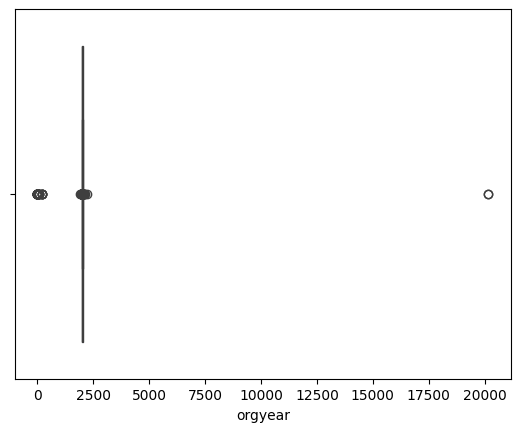

In [389]:
sns.boxplot(x = df['orgyear'])

In [390]:
# Removing the outliers from the orgyear column
q1 = df['orgyear'].quantile(0.25)
q3 = df['orgyear'].quantile(0.75)

iqr = q3 - q1 #Inter Quartile Range
# removing the outliers by filtering out the outliers (q1-1.5*iqr) and (q3+1.5*iqr)
df = df.loc[(df['orgyear'] >= (q1 - 1.5 * iqr)) & (df['orgyear'] <= (q3 + 1.5*iqr))]

<Axes: xlabel='orgyear'>

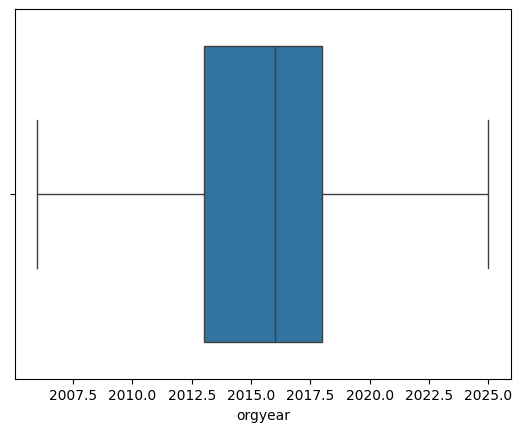

In [391]:
# Now lets try to create the box plot
sns.boxplot(x = df['orgyear'])

<Axes: xlabel='orgyear', ylabel='Count'>

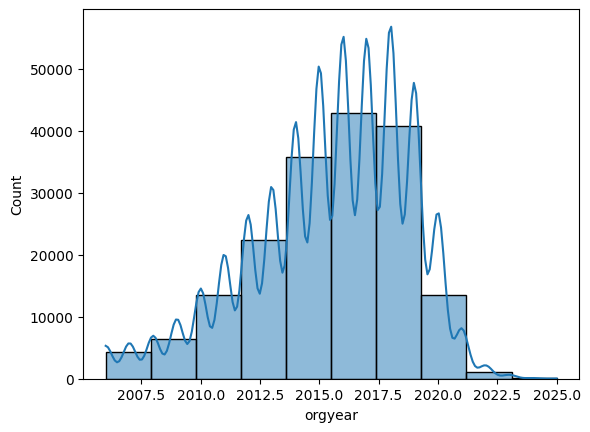

In [392]:
sns.histplot(x = df['orgyear'], bins = 10, kde = True)

<Axes: xlabel='ctc'>

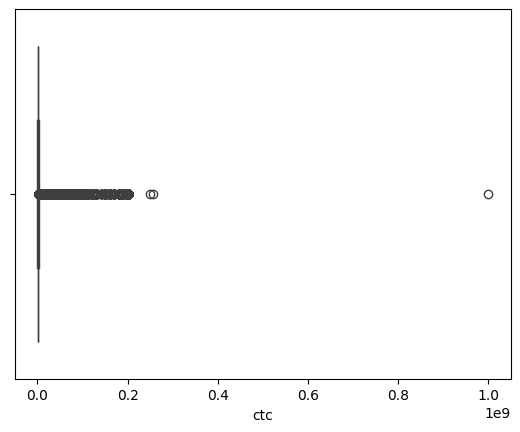

In [393]:
sns.boxplot(x = df['ctc'])

In [394]:
# Simialrly removing the outliers from the ctc column as well

# Removing the outliers from the orgyear column
q1_ctc = df['ctc'].quantile(0.25)
q3_ctc = df['ctc'].quantile(0.75)

iqr_ctc = q3_ctc - q1_ctc #Inter Quartile Range
# removing the outliers by filtering out the outliers (q1-1.5*iqr) and (q3+1.5*iqr)
df = df.loc[(df['ctc'] >= (q1_ctc - 1.5 * iqr_ctc)) & (df['ctc'] <= (q3_ctc + 1.5*iqr_ctc))]

<Axes: xlabel='ctc'>

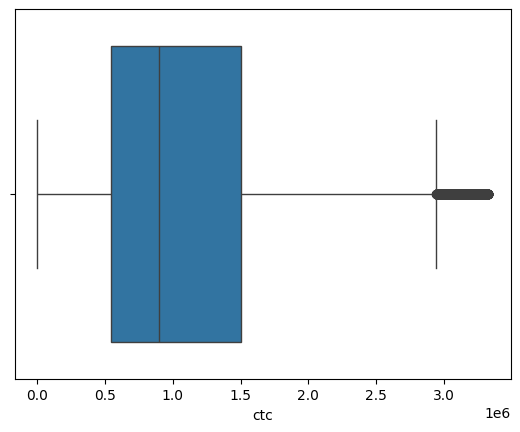

In [395]:
sns.boxplot(x = df['ctc'])

<Axes: xlabel='ctc', ylabel='Count'>

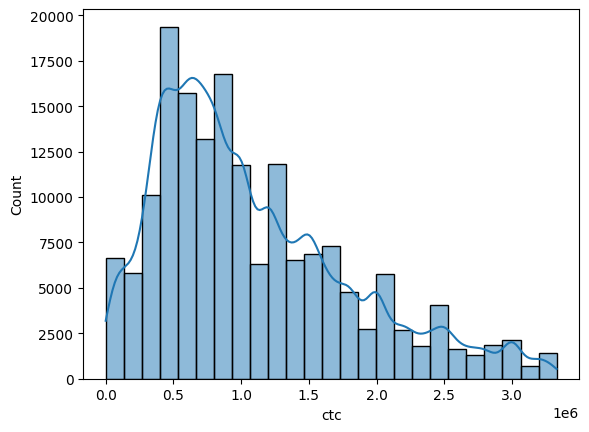

In [396]:
sns.histplot(df['ctc'], bins = 25, kde = True)

In [397]:
def numerical_feat(df,colname,nrows=2,mcols=2,width=15,height=15):
    fig , ax = plt.subplots(nrows,mcols,figsize=(width,height))
    fig.set_facecolor("lightgrey")
    rows = 0
    for var in colname:
        ax[rows][0].set_title("Boxplot for Outlier Detection ", fontweight="bold")
        plt.ylabel(var, fontsize=12)
        sns.boxplot(y = df[var],color='crimson',ax=ax[rows][0])

        # plt.subplot(nrows,mcols,pltcounter+1)
        sns.distplot(df[var],color='purple',ax=ax[rows][1])
        ax[rows][1].axvline(df[var].mean(), color='r', linestyle='--', label="Mean")
        ax[rows][1].axvline(df[var].median(), color='m', linestyle='-', label="Median")
        ax[rows][1].axvline(df[var].mode()[0], color='royalblue', linestyle='-', label="Mode")
        ax[rows][1].set_title("Outlier Detection ", fontweight="bold")
        ax[rows][1].legend({'Mean':df[var].mean(),'Median':df[var].median(),'Mode':df[var].mode()})
        rows += 1
    plt.show()

<ipython-input-397-64fc68928dbc>:11: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-397-64fc68928dbc>:11: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




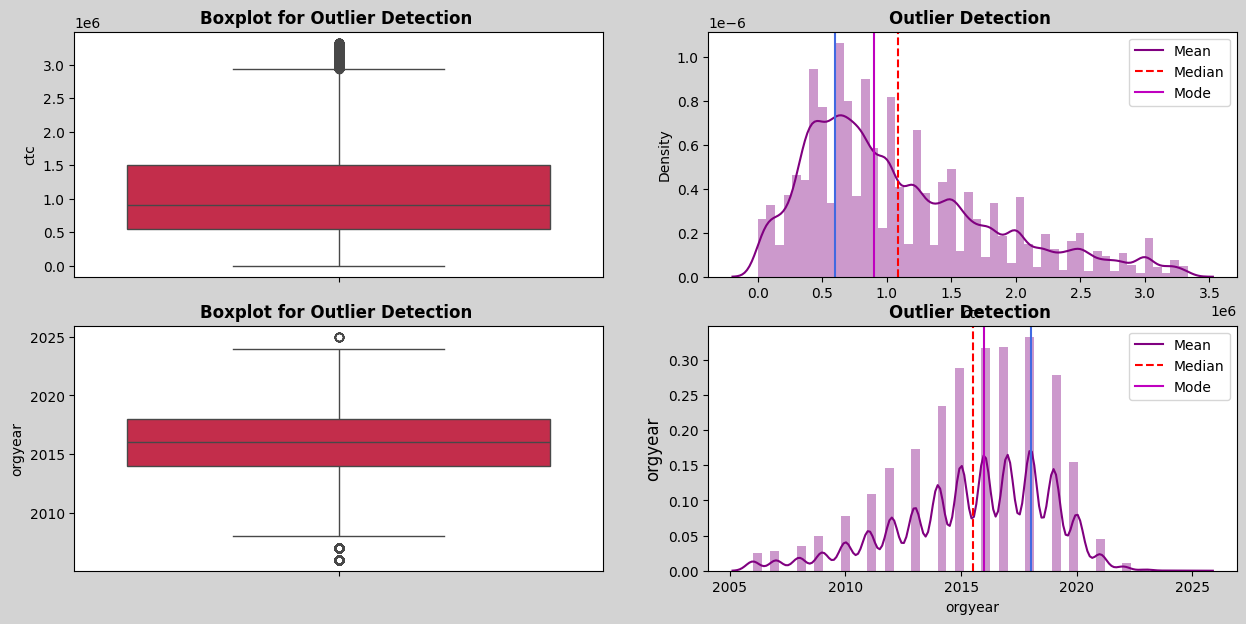

In [398]:
# We won't consider 'ctc_updated_year' as numerical but istead categorical features

numerical_cols = ['ctc', 'orgyear']
numerical_feat(df,numerical_cols,len(numerical_cols),2,15,7)

In [399]:
df.shape

(168986, 5)

In [400]:
df.drop_duplicates().shape

(168985, 5)

In [401]:
df['job_position'].sample(10)

,job_position
137565,sdet
189742,sdet
167416,fullstack engineer
157271,android engineer
947,database administrator
126038,nan
149297,data scientist
25689,data scientist
134206,backend engineer
76140,sdet


There is actually 'nan' written as text in the job position column, lets replace them with the actual NaN

In [402]:
df['job_position'].replace('nan', np.nan, inplace=True)
df['job_position'].sample(10)

<ipython-input-402-0296cf221b64>:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





,job_position
38513,fullstack engineer
125091,fullstack engineer
8496,fullstack engineer
74526,backend engineer
18485,NaN
122350,fullstack engineer
166723,frontend engineer
2068,NaN
25694,other
137390,qa engineer


In [403]:
df.isna().sum()

,0
company_hash,0
orgyear,0
ctc,0
job_position,39859
ctc_updated_year,0


#### Masking company hash as 'Others' with count < 5

In [404]:
df['company_hash'].value_counts().head()

,count
company_hash,
nvnv wgzohrnvzwj otqcxwto,4111
xzegojo,2910
vbvkgz,2227
wgszxkvzn,2115
vwwtznhqt,1998


In [405]:
# Lets map this count of each company hash in dataframe
df['company_hash'].map(df['company_hash'].value_counts()).head()
# This has replaced the actual value of company hash to the count it appears

,company_hash
0,9
1,384
2,1
3,59
4,6


In [406]:
((df['company_hash'].map(df['company_hash'].value_counts())) <= 5).head()
# Now this we can use to filter the dataframe to get the companies <=5 count

,company_hash
0,False
1,False
2,True
3,False
4,False


In [407]:
df[((df['company_hash'].map(df['company_hash'].value_counts())) <= 5)] # Dataframe with <=5 count

,company_hash,orgyear,ctc,job_position,ctc_updated_year
2,ojzwnvwnxw vx,2015.0,2000000,backend engineer,2020.0
9,xrbhd,2019.0,360000,NaN,2019.0
11,ngdor ntwy,2016.0,600000,ios engineer,2021.0
16,pnw xzaxv ucn rna,2013.0,800000,other,2020.0
21,axgz srgmvr,2006.0,1550000,engineering leadership,2019.0
...,...,...,...,...,...
205811,mrht onvnt axsxnvr,2013.0,85000,NaN,2016.0
205815,bvptbjnqxu td vbvkgz,2015.0,2400000,NaN,2019.0
205816,wgat ergf ntwy rru,2019.0,2200000,NaN,2020.0
205817,wxowg ojntbo,2011.0,3327000,NaN,2019.0


In [408]:
df['company_hash_new'] = df['company_hash'].mask(((df['company_hash'].map(df['company_hash'].value_counts())) <= 5), 'Others')
df.head()

,company_hash,orgyear,ctc,job_position,ctc_updated_year,company_hash_new
0,atrgxnnt xzaxv,2016.0,1100000,other,2020.0,atrgxnnt xzaxv
1,qtrxvzwt xzegwgbb rxbxnta,2018.0,449999,fullstack engineer,2019.0,qtrxvzwt xzegwgbb rxbxnta
2,ojzwnvwnxw vx,2015.0,2000000,backend engineer,2020.0,Others
3,ngpgutaxv,2017.0,700000,backend engineer,2019.0,ngpgutaxv
4,qxen sqghu,2017.0,1400000,fullstack engineer,2019.0,qxen sqghu


Quick check whether we masked Others for all the companies with count <=5

In [409]:
df['company_hash'][(df['company_hash_new'] == 'Others')].value_counts()

,count
company_hash,
ovqvo vzvrjnxwo,5
nqvzouvwpo ntwyzgrgsxto,5
oxtbtzo xzahonqj ogenfvqt,5
ngbxv,5
bos srgmvr ogrhnxgzo,5
...,...
mtqptrtj rvm,1
pzhastbt tdqhzzq,1
tkwqta ucn rna,1


In [410]:
# Now lets replace the values in the column 'company_hash' with Others wheres
df = df.apply(lambda x : x.mask(x.map(x.value_counts())<=5, 'Others') if x.name == 'company_hash' else x)
# by default axis = 0 is there in Pandas so this would be applied on each column instead of rows

In [411]:
df['company_hash'].value_counts().head()

,count
company_hash,
Others,46749
nvnv wgzohrnvzwj otqcxwto,4111
xzegojo,2910
vbvkgz,2227
wgszxkvzn,2115


In [412]:
df.drop('company_hash_new', axis =1, inplace = True)

In [413]:
df.shape

(168986, 5)

In [414]:
df.drop_duplicates(inplace=True)
df.shape

(147139, 5)

#### CTC updated year check

In [415]:
#CTC updated year check , if older than the Org year than update with org tear
df['ctc_updated_year'] = df.apply(lambda x : x['orgyear'] if x['ctc_updated_year'] < x['orgyear'] else x['ctc_updated_year'], axis =1)
# axis = 1 since we want to apply the fucntion on each row instead of each column

In [416]:
df.isna().sum()

,0
company_hash,0
orgyear,0
ctc,0
job_position,33384
ctc_updated_year,0


#### job position null values

In [417]:
df['job_position'] = df['job_position'].fillna('Others')
df.isna().sum()

,0
company_hash,0
orgyear,0
ctc,0
job_position,0
ctc_updated_year,0


### Feature Engineering

#### Years of Experience

In [418]:
df['orgyear'].value_counts().sort_index(ascending = False).head()
# to check the latest value of year in the data

,count
orgyear,
2025.0,11
2024.0,32
2023.0,199
2022.0,719
2021.0,2677


In [419]:
df['years_of_experience'] = 2025 - df['orgyear']
df['years_of_experience'].head()

,years_of_experience
0,9.0
1,7.0
2,10.0
3,8.0
4,8.0


In [420]:
df['years_of_experience'].isna().sum()

0

In [421]:
df.head()

,company_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_experience
0,atrgxnnt xzaxv,2016.0,1100000,other,2020.0,9.0
1,qtrxvzwt xzegwgbb rxbxnta,2018.0,449999,fullstack engineer,2019.0,7.0
2,Others,2015.0,2000000,backend engineer,2020.0,10.0
3,ngpgutaxv,2017.0,700000,backend engineer,2019.0,8.0
4,qxen sqghu,2017.0,1400000,fullstack engineer,2019.0,8.0


In [422]:
df.describe(include = 'object')

,company_hash,job_position
count,147139,147139
unique,2943,762
top,Others,Others
freq,24903,33384


In [423]:
df.describe()

,orgyear,ctc,ctc_updated_year,years_of_experience
count,147139.000000,1.471390e+05,147139.000000,147139.000000
mean,2015.483635,1.127805e+06,2019.602043,9.516365
std,3.315562,7.435977e+05,1.343787,3.315562
min,2006.000000,2.000000e+00,2015.000000,0.000000
25%,2013.000000,5.700000e+05,2019.000000,7.000000
50%,2016.000000,9.500000e+05,2020.000000,9.000000
75%,2018.000000,1.550000e+06,2021.000000,12.000000
max,2025.000000,3.330000e+06,2025.000000,19.000000


#### Definition:
- 1. Designation: Salary an employee is getting wrt salary in the same Company, Job_Position & Years of
Experience
- 2. Class: Salary an employee is getting wrt the salary in the same Company & Job_Position
- 3. Tier: Salary an employee is getting wrt the salary in the same Company

#### Manual Clustering based on company, job position and years of experience

In [424]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 147139 entries, 0 to 205842
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   company_hash         147139 non-null  object 
 1   orgyear              147139 non-null  float64
 2   ctc                  147139 non-null  int64  
 3   job_position         147139 non-null  object 
 4   ctc_updated_year     147139 non-null  float64
 5   years_of_experience  147139 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 7.9+ MB


In [425]:
grouped_c_j_y = df.groupby(['years_of_experience', 'job_position', 'company_hash'])['ctc'].describe()
grouped_c_j_y

count       mean  \
years_of_experience job_position     company_hash                               
0.0                 Others           onhatzn                   1.0  1000000.0   
                                     xzegojo                   1.0   360000.0   
                                     zgn vuurxwvmrt            1.0   100000.0   
                    backend engineer zgn vuurxwvmrt vwwghzn    1.0    56000.0   
                    devops engineer  Others                    1.0   150000.0   
...                                                            ...        ...   
19.0                support engineer xzegojo                   1.0   800000.0   
                                     xzegq                     1.0   900000.0   
                                     ywr ntwyzgrgsxto          2.0   850000.0   
                                     zvz                       1.0   400000.0   
                    team lead        utqoxontzn ojontbo        1.0  1600000.0   

                                                                       std  \
years_of_experience job_position     company_hash                            
0.0                 Others           onhatzn                           NaN   
                                     xzegojo                           NaN   
                                     zgn vuurxwvmrt                    NaN   
                    backend engineer zgn vuurxwvmrt vwwghzn            NaN   
                    devops engineer  Others                            NaN   
...                                                                    ...   
19.0                support engineer xzegojo                           NaN   
                                     xzegq                             NaN   
                                     ywr ntwyzgrgsxto        494974.746831   
                                     zvz                               NaN   
                    team lead        utqoxontzn ojontbo                NaN   

                                                                   min  \
years_of_experience job_position     company_hash                        
0.0                 Others           onhatzn                 1000000.0   
                                     xzegojo                  360000.0   
                                     zgn vuurxwvmrt           100000.0   
                    backend engineer zgn vuurxwvmrt vwwghzn    56000.0   
                    devops engineer  Others                   150000.0   
...                                                                ...   
19.0                support engineer xzegojo                  800000.0   
                                     xzegq                    900000.0   
                                     ywr ntwyzgrgsxto         500000.0   
                                     zvz                      400000.0   
                    team lead        utqoxontzn ojontbo      1600000.0   

                                                                   25%  \
years_of_experience job_position     company_hash                        
0.0                 Others           onhatzn                 1000000.0   
                                     xzegojo                  360000.0   
                                     zgn vuurxwvmrt           100000.0   
                    backend engineer zgn vuurxwvmrt vwwghzn    56000.0   
                    devops engineer  Others                   150000.0   
...                                                                ...   
19.0                support engineer xzegojo                  800000.0   
                                     xzegq                    900000.0   
                                     ywr ntwyzgrgsxto         675000.0   
                                     zvz                      400000.0   
                    team lead        utqoxontzn ojontbo      1600000.0   

                                                                  

In [426]:
df_cjy = df.merge(grouped_c_j_y, on = ['years_of_experience', 'job_position', 'company_hash'], how = 'left')
df_cjy

,company_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_experience,count,mean,std,min,25%,50%,75%,max
0,atrgxnnt xzaxv,2016.0,1100000,other,2020.0,9.0,1.0,1.100000e+06,NaN,1100000.0,1100000.0,1100000.0,1100000.0,1100000.0
1,qtrxvzwt xzegwgbb rxbxnta,2018.0,449999,fullstack engineer,2019.0,7.0,7.0,7.742856e+05,250922.324350,449999.0,610000.0,750000.0,900000.0,1200000.0
2,Others,2015.0,2000000,backend engineer,2020.0,10.0,456.0,9.609559e+05,776546.830662,1000.0,307500.0,800000.0,1435000.0,3200000.0
3,ngpgutaxv,2017.0,700000,backend engineer,2019.0,8.0,7.0,1.158571e+06,404780.951933,700000.0,825000.0,1200000.0,1405000.0,1750000.0
4,qxen sqghu,2017.0,1400000,fullstack engineer,2019.0,8.0,1.0,1.400000e+06,NaN,1400000.0,1400000.0,1400000.0,1400000.0,1400000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147134,mvqwrvjo,2011.0,2250000,Others,2019.0,14.0,11.0,1.427273e+06,468638.192678,530000.0,1250000.0,1350000.0,1634999.5,2250000.0
147135,vuurt xzw,2008.0,220000,Others,2019.0,17.0,1.0,2.200000e+05,NaN,220000.0,220000.0,220000.0,220000.0,220000.0
147136,husqvawgb,2017.0,500000,Others,2020.0,8.0,4.0,1.202500e+06,471902.179129,500000.0,1145000.0,1405000.0,1462500.0,1500000.0
147137,vwwgrxnt,2021.0,700000,Others,2021.0,4.0,3.0,6.666667e+05,351188.458428,300000.0,500000.0,700000.0,850000.0,1000000.0


In [427]:
df_cjy.sort_values(['years_of_experience', 'job_position', 'company_hash'])

,company_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_experience,count,mean,std,min,25%,50%,75%,max
69753,onhatzn,2025.0,1000000,Others,2025.0,0.0,1.0,1000000.0,NaN,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0
16565,xzegojo,2025.0,360000,Others,2025.0,0.0,1.0,360000.0,NaN,360000.0,360000.0,360000.0,360000.0,360000.0
47251,zgn vuurxwvmrt,2025.0,100000,Others,2025.0,0.0,1.0,100000.0,NaN,100000.0,100000.0,100000.0,100000.0,100000.0
80802,zgn vuurxwvmrt vwwghzn,2025.0,56000,backend engineer,2025.0,0.0,1.0,56000.0,NaN,56000.0,56000.0,56000.0,56000.0,56000.0
81991,Others,2025.0,150000,devops engineer,2025.0,0.0,1.0,150000.0,NaN,150000.0,150000.0,150000.0,150000.0,150000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73964,xzegq,2006.0,900000,support engineer,2021.0,19.0,1.0,900000.0,NaN,900000.0,900000.0,900000.0,900000.0,900000.0
11374,ywr ntwyzgrgsxto,2006.0,500000,support engineer,2021.0,19.0,2.0,850000.0,494974.746831,500000.0,675000.0,850000.0,1025000.0,1200000.0
37281,ywr ntwyzgrgsxto,2006.0,1200000,support engineer,2021.0,19.0,2.0,850000.0,494974.746831,500000.0,675000.0,850000.0,1025000.0,1200000.0
14290,zvz,2006.0,400000,support engineer,2021.0,19.0,1.0,400000.0,NaN,400000.0,400000.0,400000.0,400000.0,400000.0


In [428]:
df_cjy.drop_duplicates(inplace=True)
df_cjy.shape

(146104, 14)

##### Creating the designation based on the salary in same company, job_position and year_of_exp


In [429]:
def cond_designation(sal, sal_50, sal_75):
  if sal < sal_50:
    return 3
  elif sal > sal_50 and sal < sal_75:
    return 2
  else:
    return 1

In [430]:
df_cjy.head()

,company_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_experience,count,mean,std,min,25%,50%,75%,max
0,atrgxnnt xzaxv,2016.0,1100000,other,2020.0,9.0,1.0,1.100000e+06,NaN,1100000.0,1100000.0,1100000.0,1100000.0,1100000.0
1,qtrxvzwt xzegwgbb rxbxnta,2018.0,449999,fullstack engineer,2019.0,7.0,7.0,7.742856e+05,250922.324350,449999.0,610000.0,750000.0,900000.0,1200000.0
2,Others,2015.0,2000000,backend engineer,2020.0,10.0,456.0,9.609559e+05,776546.830662,1000.0,307500.0,800000.0,1435000.0,3200000.0
3,ngpgutaxv,2017.0,700000,backend engineer,2019.0,8.0,7.0,1.158571e+06,404780.951933,700000.0,825000.0,1200000.0,1405000.0,1750000.0
4,qxen sqghu,2017.0,1400000,fullstack engineer,2019.0,8.0,1.0,1.400000e+06,NaN,1400000.0,1400000.0,1400000.0,1400000.0,1400000.0


In [431]:
# creating a new column for designation based on the above function
df_cjy['designation'] = df_cjy.apply(lambda x : cond_designation(x['ctc'], x['50%'], x['75%']), axis =1) #axis =1 since we are applying this on each row of the ctc column
df_cjy.head()

,company_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_experience,count,mean,std,min,25%,50%,75%,max,designation
0,atrgxnnt xzaxv,2016.0,1100000,other,2020.0,9.0,1.0,1.100000e+06,NaN,1100000.0,1100000.0,1100000.0,1100000.0,1100000.0,1
1,qtrxvzwt xzegwgbb rxbxnta,2018.0,449999,fullstack engineer,2019.0,7.0,7.0,7.742856e+05,250922.324350,449999.0,610000.0,750000.0,900000.0,1200000.0,3
2,Others,2015.0,2000000,backend engineer,2020.0,10.0,456.0,9.609559e+05,776546.830662,1000.0,307500.0,800000.0,1435000.0,3200000.0,1
3,ngpgutaxv,2017.0,700000,backend engineer,2019.0,8.0,7.0,1.158571e+06,404780.951933,700000.0,825000.0,1200000.0,1405000.0,1750000.0,3
4,qxen sqghu,2017.0,1400000,fullstack engineer,2019.0,8.0,1.0,1.400000e+06,NaN,1400000.0,1400000.0,1400000.0,1400000.0,1400000.0,1


In [432]:
df_cjy.shape

(146104, 15)

In [433]:
df_cjy['designation'].value_counts(normalize = True)*100

,proportion
designation,
1,55.111427
3,34.147593
2,10.740979


#### Manual Clustering based on company and job position

In [434]:
grouped_c_j = df.groupby(['job_position', 'company_hash'])['ctc'].describe()
grouped_c_j

count  \
job_position          company_hash                                       
Others                Others                                    3296.0   
                      a ntwyzgrgsxto                               5.0   
                      aaqxctz avnv owxtzwto  vzvrjnxwo ucn rna     1.0   
                      adw ntwyzgrgsj                              59.0   
                      adw ntwyzgrgsxto                            37.0   
...                                                                ...   
wordpress developer   Others                                       1.0   
worker                zgn vuurxwvmrt vwwghzn                       1.0   
x                     Others                                       1.0   
young professional ii sgctqzbtzn ge xzaxv                          1.0   
zomato                kgbvng                                       1.0   

                                                                        mean  \
job_position          company_hash                                             
Others                Others                                    1.021510e+06   
                      a ntwyzgrgsxto                            6.750000e+05   
                      aaqxctz avnv owxtzwto  vzvrjnxwo ucn rna  5.000000e+05   
                      adw ntwyzgrgsj                            6.451864e+05   
                      adw ntwyzgrgsxto                          6.230000e+05   
...                                                                      ...   
wordpress developer   Others                                    6.000000e+05   
worker                zgn vuurxwvmrt vwwghzn                    2.000000e+05   
x                     Others                                    4.000000e+05   
young professional ii sgctqzbtzn ge xzaxv                       5.000000e+05   
zomato                kgbvng                                    5.000000e+05   

                                                                          std  \
job_position          company_hash                                              
Others                Others                                    832031.028338   
                      a ntwyzgrgsxto                            389711.431703   
                      aaqxctz avnv owxtzwto  vzvrjnxwo ucn rna            NaN   
                      adw ntwyzgrgsj                            449039.606370   
                      adw ntwyzgrgsxto                          323412.705035   
...                                                                       ...   
wordpress developer   Others                                              NaN   
worker                zgn vuurxwvmrt vwwghzn                              NaN   
x                     Others                                              NaN   
young professional ii sgctqzbtzn ge xzaxv                                 NaN   
zomato                kgbvng                                              NaN   

                                                                     min  \
job_position          company_hash                                         
Others                Others                                        15.0   
                      a ntwyzgrgsxto                            350000.0   
                      aaqxctz avnv owxtzwto  vzvrjnxwo ucn rna  500000.0   
                      adw ntwyzgrgsj                             80000.0   
                      adw ntwyzgrgsxto                          100000.0   
...                                                                  ...   
wordpress developer   Others                                    600000.0   
worker                zgn vuurxwvmrt vwwghzn                    200000.0   
x                     Others                                    400000.0   
young professional ii sgctqzbtzn ge xzaxv                       500000.0   
zomato                kgbvng                                    500000.0   

                  

In [435]:
df_cj = df.merge(grouped_c_j, on = ['job_position', 'company_hash'], how = 'left') #merging the above grouped df into the main dataframe
df_cj

,company_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_experience,count,mean,std,min,25%,50%,75%,max
0,atrgxnnt xzaxv,2016.0,1100000,other,2020.0,9.0,2.0,1.085000e+06,2.121320e+04,1070000.0,1077500.0,1085000.0,1092500.0,1100000.0
1,qtrxvzwt xzegwgbb rxbxnta,2018.0,449999,fullstack engineer,2019.0,7.0,25.0,9.882000e+05,4.874998e+05,300000.0,600000.0,850000.0,1380000.0,2000000.0
2,Others,2015.0,2000000,backend engineer,2020.0,10.0,3927.0,9.958526e+05,8.105078e+05,1000.0,300000.0,819999.0,1510000.0,3300000.0
3,ngpgutaxv,2017.0,700000,backend engineer,2019.0,8.0,24.0,1.416667e+06,5.453413e+05,520000.0,1047500.0,1375000.0,1792500.0,2600000.0
4,qxen sqghu,2017.0,1400000,fullstack engineer,2019.0,8.0,3.0,8.466667e+05,4.801389e+05,540000.0,570000.0,600000.0,1000000.0,1400000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147134,mvqwrvjo,2011.0,2250000,Others,2019.0,14.0,64.0,1.259969e+06,5.777488e+05,500000.0,800000.0,1020000.0,1607500.0,3200000.0
147135,vuurt xzw,2008.0,220000,Others,2019.0,17.0,16.0,1.568312e+06,1.231984e+06,60000.0,216250.0,2275000.0,2550000.0,3000000.0
147136,husqvawgb,2017.0,500000,Others,2020.0,8.0,13.0,1.000769e+06,3.300369e+05,500000.0,750000.0,1000000.0,1200000.0,1500000.0
147137,vwwgrxnt,2021.0,700000,Others,2021.0,4.0,35.0,1.200371e+06,5.635221e+05,300000.0,771500.0,1100000.0,1400000.0,2700000.0


In [436]:
df_cj.sort_values(['company_hash','job_position','years_of_experience'])

,company_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_experience,count,mean,std,min,25%,50%,75%,max
130105,Others,2024.0,1760000,Others,2024.0,1.0,3296.0,1.021510e+06,832031.028338,15.0,360000.0,800000.0,1500000.0,3327000.0
8804,Others,2023.0,680000,Others,2023.0,2.0,3296.0,1.021510e+06,832031.028338,15.0,360000.0,800000.0,1500000.0,3327000.0
38267,Others,2023.0,110000,Others,2023.0,2.0,3296.0,1.021510e+06,832031.028338,15.0,360000.0,800000.0,1500000.0,3327000.0
41698,Others,2023.0,80000,Others,2023.0,2.0,3296.0,1.021510e+06,832031.028338,15.0,360000.0,800000.0,1500000.0,3327000.0
54530,Others,2023.0,700000,Others,2023.0,2.0,3296.0,1.021510e+06,832031.028338,15.0,360000.0,800000.0,1500000.0,3327000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122931,zxztrtvuo,2013.0,1200000,ios engineer,2017.0,12.0,1.0,1.200000e+06,NaN,1200000.0,1200000.0,1200000.0,1200000.0,1200000.0
53944,zxztrtvuo,2016.0,1200000,member of technical staff at nineleaps,2020.0,9.0,1.0,1.200000e+06,NaN,1200000.0,1200000.0,1200000.0,1200000.0,1200000.0
9204,zxztrtvuo,2020.0,450000,other,2020.0,5.0,2.0,4.500000e+05,0.000000,450000.0,450000.0,450000.0,450000.0,450000.0
134140,zxztrtvuo,2019.0,450000,other,2020.0,6.0,2.0,4.500000e+05,0.000000,450000.0,450000.0,450000.0,450000.0,450000.0


In [437]:
df_cj.shape

(147139, 14)

In [438]:
df_cj.drop_duplicates(inplace = True)
df_cj.shape # changes in the number of rows

(146104, 14)

##### Creating the class based on the salary they are getting in same company and job_position

In [439]:
def cond_class(sal, sal_50, sal_75):
  if sal < sal_50:
    return 3
  elif sal > sal_50 and sal < sal_75:
    return 2
  else:
    return 1

In [440]:
df_cj.head()

,company_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_experience,count,mean,std,min,25%,50%,75%,max
0,atrgxnnt xzaxv,2016.0,1100000,other,2020.0,9.0,2.0,1.085000e+06,21213.203436,1070000.0,1077500.0,1085000.0,1092500.0,1100000.0
1,qtrxvzwt xzegwgbb rxbxnta,2018.0,449999,fullstack engineer,2019.0,7.0,25.0,9.882000e+05,487499.789590,300000.0,600000.0,850000.0,1380000.0,2000000.0
2,Others,2015.0,2000000,backend engineer,2020.0,10.0,3927.0,9.958526e+05,810507.825376,1000.0,300000.0,819999.0,1510000.0,3300000.0
3,ngpgutaxv,2017.0,700000,backend engineer,2019.0,8.0,24.0,1.416667e+06,545341.270627,520000.0,1047500.0,1375000.0,1792500.0,2600000.0
4,qxen sqghu,2017.0,1400000,fullstack engineer,2019.0,8.0,3.0,8.466667e+05,480138.868801,540000.0,570000.0,600000.0,1000000.0,1400000.0


In [441]:
# creating a new column for Class based on the above function
df_cj['class'] = df_cj.apply(lambda x : cond_class(x['ctc'], x['50%'], x['75%']), axis =1) #axis = 1 since we are applying this on each row of the ctc column
df_cj.head()

,company_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_experience,count,mean,std,min,25%,50%,75%,max,class
0,atrgxnnt xzaxv,2016.0,1100000,other,2020.0,9.0,2.0,1.085000e+06,21213.203436,1070000.0,1077500.0,1085000.0,1092500.0,1100000.0,1
1,qtrxvzwt xzegwgbb rxbxnta,2018.0,449999,fullstack engineer,2019.0,7.0,25.0,9.882000e+05,487499.789590,300000.0,600000.0,850000.0,1380000.0,2000000.0,3
2,Others,2015.0,2000000,backend engineer,2020.0,10.0,3927.0,9.958526e+05,810507.825376,1000.0,300000.0,819999.0,1510000.0,3300000.0,1
3,ngpgutaxv,2017.0,700000,backend engineer,2019.0,8.0,24.0,1.416667e+06,545341.270627,520000.0,1047500.0,1375000.0,1792500.0,2600000.0,3
4,qxen sqghu,2017.0,1400000,fullstack engineer,2019.0,8.0,3.0,8.466667e+05,480138.868801,540000.0,570000.0,600000.0,1000000.0,1400000.0,1


In [442]:
df_cj['class'].value_counts(normalize=True)*100

,proportion
class,
3,43.690796
1,39.528692
2,16.780513


In [443]:
# Job position that has tha highest class - doing the descriptive analysis
df_cj[df_cj['class']==1][['job_position', 'ctc']].groupby(['job_position'])['ctc'].describe()

#this is all the job with class =1 and their statistics

,count,mean,std,min,25%,50%,75%,max
job_position,,,,,,,,
Others,11608.0,1.711395e+06,750078.168098,2400.0,1100000.0,1632500.0,2300000.0,3330000.0
a group chat application,1.0,5.000000e+05,NaN,500000.0,500000.0,500000.0,500000.0,500000.0
abap developer,1.0,5.000000e+05,NaN,500000.0,500000.0,500000.0,500000.0,500000.0
account,1.0,2.000000e+06,NaN,2000000.0,2000000.0,2000000.0,2000000.0,2000000.0
administrative clerk,1.0,5.000000e+05,NaN,500000.0,500000.0,500000.0,500000.0,500000.0
...,...,...,...,...,...,...,...,...
wordpress developer,1.0,6.000000e+05,NaN,600000.0,600000.0,600000.0,600000.0,600000.0
worker,1.0,2.000000e+05,NaN,200000.0,200000.0,200000.0,200000.0,200000.0
x,1.0,4.000000e+05,NaN,400000.0,400000.0,400000.0,400000.0,400000.0


In [444]:
df_cjy.head()

,company_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_experience,count,mean,std,min,25%,50%,75%,max,designation
0,atrgxnnt xzaxv,2016.0,1100000,other,2020.0,9.0,1.0,1.100000e+06,NaN,1100000.0,1100000.0,1100000.0,1100000.0,1100000.0,1
1,qtrxvzwt xzegwgbb rxbxnta,2018.0,449999,fullstack engineer,2019.0,7.0,7.0,7.742856e+05,250922.324350,449999.0,610000.0,750000.0,900000.0,1200000.0,3
2,Others,2015.0,2000000,backend engineer,2020.0,10.0,456.0,9.609559e+05,776546.830662,1000.0,307500.0,800000.0,1435000.0,3200000.0,1
3,ngpgutaxv,2017.0,700000,backend engineer,2019.0,8.0,7.0,1.158571e+06,404780.951933,700000.0,825000.0,1200000.0,1405000.0,1750000.0,3
4,qxen sqghu,2017.0,1400000,fullstack engineer,2019.0,8.0,1.0,1.400000e+06,NaN,1400000.0,1400000.0,1400000.0,1400000.0,1400000.0,1


In [445]:
df_cj.head()

,company_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_experience,count,mean,std,min,25%,50%,75%,max,class
0,atrgxnnt xzaxv,2016.0,1100000,other,2020.0,9.0,2.0,1.085000e+06,21213.203436,1070000.0,1077500.0,1085000.0,1092500.0,1100000.0,1
1,qtrxvzwt xzegwgbb rxbxnta,2018.0,449999,fullstack engineer,2019.0,7.0,25.0,9.882000e+05,487499.789590,300000.0,600000.0,850000.0,1380000.0,2000000.0,3
2,Others,2015.0,2000000,backend engineer,2020.0,10.0,3927.0,9.958526e+05,810507.825376,1000.0,300000.0,819999.0,1510000.0,3300000.0,1
3,ngpgutaxv,2017.0,700000,backend engineer,2019.0,8.0,24.0,1.416667e+06,545341.270627,520000.0,1047500.0,1375000.0,1792500.0,2600000.0,3
4,qxen sqghu,2017.0,1400000,fullstack engineer,2019.0,8.0,3.0,8.466667e+05,480138.868801,540000.0,570000.0,600000.0,1000000.0,1400000.0,1


In [446]:
df_cjy.shape

(146104, 15)

In [447]:
df_cj.shape

(146104, 15)

In [448]:
df_cj.drop(columns=['count','mean','std','min','25%','50%','75%','max'],inplace=True)
df_cjy.drop(columns=['count','mean','std','min','25%','50%','75%','max'],inplace=True)

In [449]:
df_cjy.drop_duplicates().shape

(146104, 7)

In [450]:
df_cj.drop_duplicates().shape

(146104, 7)

In [451]:
df_cjy.head()

,company_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_experience,designation
0,atrgxnnt xzaxv,2016.0,1100000,other,2020.0,9.0,1
1,qtrxvzwt xzegwgbb rxbxnta,2018.0,449999,fullstack engineer,2019.0,7.0,3
2,Others,2015.0,2000000,backend engineer,2020.0,10.0,1
3,ngpgutaxv,2017.0,700000,backend engineer,2019.0,8.0,3
4,qxen sqghu,2017.0,1400000,fullstack engineer,2019.0,8.0,1


In [452]:
df_cj.head()

,company_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_experience,class
0,atrgxnnt xzaxv,2016.0,1100000,other,2020.0,9.0,1
1,qtrxvzwt xzegwgbb rxbxnta,2018.0,449999,fullstack engineer,2019.0,7.0,3
2,Others,2015.0,2000000,backend engineer,2020.0,10.0,1
3,ngpgutaxv,2017.0,700000,backend engineer,2019.0,8.0,3
4,qxen sqghu,2017.0,1400000,fullstack engineer,2019.0,8.0,1


##### merging both class and designation columns into df_cj


In [453]:
df_cjy_cj = df_cj.merge(df_cjy, on = ['company_hash', 'orgyear', 'ctc', 'job_position', 'ctc_updated_year', 'years_of_experience'], how = 'right') # add all rows from df_cjy
df_cjy_cj

,company_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_experience,class,designation
0,atrgxnnt xzaxv,2016.0,1100000,other,2020.0,9.0,1,1
1,qtrxvzwt xzegwgbb rxbxnta,2018.0,449999,fullstack engineer,2019.0,7.0,3,3
2,Others,2015.0,2000000,backend engineer,2020.0,10.0,1,1
3,ngpgutaxv,2017.0,700000,backend engineer,2019.0,8.0,3,3
4,qxen sqghu,2017.0,1400000,fullstack engineer,2019.0,8.0,1,1
...,...,...,...,...,...,...,...,...
146099,mvqwrvjo,2011.0,2250000,Others,2019.0,14.0,1,1
146100,vuurt xzw,2008.0,220000,Others,2019.0,17.0,3,1
146101,husqvawgb,2017.0,500000,Others,2020.0,8.0,3,3
146102,vwwgrxnt,2021.0,700000,Others,2021.0,4.0,3,1


In [454]:
df_cjy_cj.shape

(146104, 8)

No change in row count, all the rows considered after the merge

#### Manual Clustering based on company

In [455]:
grouped_c = df.groupby(['company_hash'])['ctc'].describe()
grouped_c

,count,mean,std,min,25%,50%,75%,max
company_hash,,,,,,,,
Others,24903.0,9.647442e+05,760124.617272,15.0,390000.0,800000.0,1400000.0,3329999.0
a ntwyzgrgsxto,14.0,8.396429e+05,733360.191400,350000.0,500000.0,600000.0,687500.0,3150000.0
aaqxctz avnv owxtzwto vzvrjnxwo ucn rna,7.0,6.114286e+05,362373.130508,360000.0,430000.0,500000.0,580000.0,1400000.0
adw ntwyzgrgsj,250.0,7.389400e+05,506158.686706,32000.0,400000.0,585000.0,900000.0,3200000.0
adw ntwyzgrgsxto,127.0,6.949842e+05,374707.399481,100000.0,403500.0,600000.0,900000.0,2350000.0
...,...,...,...,...,...,...,...,...
zxxn rna,7.0,9.014286e+05,519436.507876,280000.0,500000.0,810000.0,1260000.0,1700000.0
zxyxrtzn,8.0,6.887500e+05,322155.131220,330000.0,420000.0,715000.0,812500.0,1300000.0
zxyxrtzn ntwyzgrgsxto,12.0,8.170000e+05,394381.909967,50000.0,590000.0,800000.0,992500.0,1500000.0


In [456]:
# merging this with dataframe
df_c = df.merge(grouped_c, on = ['company_hash'], how = 'left') #df will have all its rows and on that grouped_c will be merged for matching company names
df_c.head()

,company_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_experience,count,mean,std,min,25%,50%,75%,max
0,atrgxnnt xzaxv,2016.0,1100000,other,2020.0,9.0,9.0,1.115667e+06,458111.885897,500000.0,800000.0,1070000.0,1500000.0,1771000.0
1,qtrxvzwt xzegwgbb rxbxnta,2018.0,449999,fullstack engineer,2019.0,7.0,384.0,1.055291e+06,636095.670307,10000.0,600000.0,850000.0,1500000.0,3200000.0
2,Others,2015.0,2000000,backend engineer,2020.0,10.0,24903.0,9.647442e+05,760124.617272,15.0,390000.0,800000.0,1400000.0,3329999.0
3,ngpgutaxv,2017.0,700000,backend engineer,2019.0,8.0,59.0,1.455508e+06,655423.458086,200000.0,1075000.0,1300000.0,1850000.0,3160000.0
4,qxen sqghu,2017.0,1400000,fullstack engineer,2019.0,8.0,6.0,9.400000e+05,389871.773792,540000.0,625000.0,850000.0,1300000.0,1400000.0


In [457]:
# lets verify whether it is done properly or not
df_c.sort_values(by = ['company_hash'])
# we can see that for 'Others' as company, merged values are same for descriptive statistics

,company_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_experience,count,mean,std,min,25%,50%,75%,max
30026,Others,2017.0,730000,ios engineer,2020.0,8.0,24903.0,964744.216801,760124.617272,15.0,390000.0,800000.0,1400000.0,3329999.0
37763,Others,2021.0,1200000,Others,2021.0,4.0,24903.0,964744.216801,760124.617272,15.0,390000.0,800000.0,1400000.0,3329999.0
76928,Others,2022.0,1410000,Others,2022.0,3.0,24903.0,964744.216801,760124.617272,15.0,390000.0,800000.0,1400000.0,3329999.0
17694,Others,2012.0,900000,fullstack engineer,2020.0,13.0,24903.0,964744.216801,760124.617272,15.0,390000.0,800000.0,1400000.0,3329999.0
76939,Others,2019.0,1900000,Others,2021.0,6.0,24903.0,964744.216801,760124.617272,15.0,390000.0,800000.0,1400000.0,3329999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38317,zxztrtvuo,2015.0,1200000,Others,2019.0,10.0,69.0,957217.376812,564608.271459,400000.0,500000.0,750000.0,1200000.0,2700000.0
7924,zxztrtvuo,2019.0,500000,frontend engineer,2020.0,6.0,69.0,957217.376812,564608.271459,400000.0,500000.0,750000.0,1200000.0,2700000.0
109775,zxztrtvuo,2016.0,880000,frontend engineer,2019.0,9.0,69.0,957217.376812,564608.271459,400000.0,500000.0,750000.0,1200000.0,2700000.0
1738,zxztrtvuo,2019.0,550000,frontend engineer,2020.0,6.0,69.0,957217.376812,564608.271459,400000.0,500000.0,750000.0,1200000.0,2700000.0


In [458]:
df_c.shape

(147139, 14)

In [459]:
df_c.drop_duplicates(inplace = True)

In [460]:
df_c.shape

(146104, 14)

##### Creating the Tier based on salary in the same company

In [461]:
def cond_tier(sal, sal_50, sal_75):
  if sal < sal_50:
    return 3
  elif sal > sal_50 and sal < sal_75:
    return 2
  else:
    return 1

In [462]:
df_c['tier'] = df_c.apply(lambda x : cond_tier(x['ctc'], x['50%'], x['75%']), axis =1 ) # axis = 1 since we want to apply this on each row of the ctc column
df_c.head()

,company_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_experience,count,mean,std,min,25%,50%,75%,max,tier
0,atrgxnnt xzaxv,2016.0,1100000,other,2020.0,9.0,9.0,1.115667e+06,458111.885897,500000.0,800000.0,1070000.0,1500000.0,1771000.0,2
1,qtrxvzwt xzegwgbb rxbxnta,2018.0,449999,fullstack engineer,2019.0,7.0,384.0,1.055291e+06,636095.670307,10000.0,600000.0,850000.0,1500000.0,3200000.0,3
2,Others,2015.0,2000000,backend engineer,2020.0,10.0,24903.0,9.647442e+05,760124.617272,15.0,390000.0,800000.0,1400000.0,3329999.0,1
3,ngpgutaxv,2017.0,700000,backend engineer,2019.0,8.0,59.0,1.455508e+06,655423.458086,200000.0,1075000.0,1300000.0,1850000.0,3160000.0,3
4,qxen sqghu,2017.0,1400000,fullstack engineer,2019.0,8.0,6.0,9.400000e+05,389871.773792,540000.0,625000.0,850000.0,1300000.0,1400000.0,1


In [463]:
df_c['tier'].value_counts(normalize = True)* 100

,proportion
tier,
3,47.948037
1,31.387915
2,20.664048


##### Merging the tier with designation and class

In [464]:
df_cjy_cj.head()

,company_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_experience,class,designation
0,atrgxnnt xzaxv,2016.0,1100000,other,2020.0,9.0,1,1
1,qtrxvzwt xzegwgbb rxbxnta,2018.0,449999,fullstack engineer,2019.0,7.0,3,3
2,Others,2015.0,2000000,backend engineer,2020.0,10.0,1,1
3,ngpgutaxv,2017.0,700000,backend engineer,2019.0,8.0,3,3
4,qxen sqghu,2017.0,1400000,fullstack engineer,2019.0,8.0,1,1


In [465]:
df_cjy_cj_c = df_cjy_cj.merge(df_c, on = ['company_hash', 'orgyear', 'ctc', 'job_position', 'ctc_updated_year', 'years_of_experience'], how = 'left')
df_cjy_cj_c.head()

,company_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_experience,class,designation,count,mean,std,min,25%,50%,75%,max,tier
0,atrgxnnt xzaxv,2016.0,1100000,other,2020.0,9.0,1,1,9.0,1.115667e+06,458111.885897,500000.0,800000.0,1070000.0,1500000.0,1771000.0,2
1,qtrxvzwt xzegwgbb rxbxnta,2018.0,449999,fullstack engineer,2019.0,7.0,3,3,384.0,1.055291e+06,636095.670307,10000.0,600000.0,850000.0,1500000.0,3200000.0,3
2,Others,2015.0,2000000,backend engineer,2020.0,10.0,1,1,24903.0,9.647442e+05,760124.617272,15.0,390000.0,800000.0,1400000.0,3329999.0,1
3,ngpgutaxv,2017.0,700000,backend engineer,2019.0,8.0,3,3,59.0,1.455508e+06,655423.458086,200000.0,1075000.0,1300000.0,1850000.0,3160000.0,3
4,qxen sqghu,2017.0,1400000,fullstack engineer,2019.0,8.0,1,1,6.0,9.400000e+05,389871.773792,540000.0,625000.0,850000.0,1300000.0,1400000.0,1


In [466]:
df_cjy_cj_c.shape

(146104, 17)

In [467]:
df_cjy_cj_c.drop_duplicates(inplace = True)
df_cjy_cj_c.shape

(146104, 17)

In [468]:
data = df_cjy_cj_c.copy(deep = True) # deep = True ensure deepcopy of the orginal dataframe and any changes in new dataframe doesn't affect the original dataframe
data.head()

,company_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_experience,class,designation,count,mean,std,min,25%,50%,75%,max,tier
0,atrgxnnt xzaxv,2016.0,1100000,other,2020.0,9.0,1,1,9.0,1.115667e+06,458111.885897,500000.0,800000.0,1070000.0,1500000.0,1771000.0,2
1,qtrxvzwt xzegwgbb rxbxnta,2018.0,449999,fullstack engineer,2019.0,7.0,3,3,384.0,1.055291e+06,636095.670307,10000.0,600000.0,850000.0,1500000.0,3200000.0,3
2,Others,2015.0,2000000,backend engineer,2020.0,10.0,1,1,24903.0,9.647442e+05,760124.617272,15.0,390000.0,800000.0,1400000.0,3329999.0,1
3,ngpgutaxv,2017.0,700000,backend engineer,2019.0,8.0,3,3,59.0,1.455508e+06,655423.458086,200000.0,1075000.0,1300000.0,1850000.0,3160000.0,3
4,qxen sqghu,2017.0,1400000,fullstack engineer,2019.0,8.0,1,1,6.0,9.400000e+05,389871.773792,540000.0,625000.0,850000.0,1300000.0,1400000.0,1


In [469]:
data.drop(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'],axis =1, inplace = True)
data.head()

,company_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_experience,class,designation,tier
0,atrgxnnt xzaxv,2016.0,1100000,other,2020.0,9.0,1,1,2
1,qtrxvzwt xzegwgbb rxbxnta,2018.0,449999,fullstack engineer,2019.0,7.0,3,3,3
2,Others,2015.0,2000000,backend engineer,2020.0,10.0,1,1,1
3,ngpgutaxv,2017.0,700000,backend engineer,2019.0,8.0,3,3,3
4,qxen sqghu,2017.0,1400000,fullstack engineer,2019.0,8.0,1,1,1


#### Insights based on Manual clustering

##### Top 10 employees (earning more than most of the employees in the company) - Tier 1

In [470]:
data[data['tier'] == 1].sort_values(by = 'ctc', ascending = False).head(10)

,company_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_experience,class,designation,tier
124491,bxwqgogen qtotvqwy xzaxv,2017.0,3330000,Others,2021.0,8.0,1,1,1
97122,bxwqgogen qtotvqwy xzaxv,2017.0,3330000,research engineers,2021.0,8.0,1,1,1
123530,btaxvpxza,2009.0,3330000,backend engineer,2021.0,16.0,1,1,1
86317,uvjovet sqghu,2015.0,3330000,backend engineer,2020.0,10.0,1,1,1
135444,btaxvpxza,2009.0,3330000,fullstack engineer,2021.0,16.0,1,1,1
129661,Others,2010.0,3329999,program manager,2019.0,15.0,1,1,1
134640,Others,2006.0,3329999,backend architect,2019.0,19.0,1,1,1
49802,uvjnb,2009.0,3329999,sdet,2019.0,16.0,1,1,1
99680,mtwpbvz wghrntq,2006.0,3329999,engineering leadership,2019.0,19.0,1,1,1
41877,nvnv wrxi,2009.0,3329999,product designer,2017.0,16.0,1,1,1


##### Top 10 employees of data science in each company earning more than their peers - Class 1

In [471]:
sorted_data = data[(data['class'] == 1) & (data['job_position'] == 'data scientist')].sort_values(by = ['company_hash', 'ctc'], ascending = [True, False])

In [472]:
sorted_data.groupby(['company_hash']).head(10)

,company_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_experience,class,designation,tier
143492,Others,2015.0,3310000,data scientist,2020.0,10.0,1,1,1
87555,Others,2008.0,3300000,data scientist,2019.0,17.0,1,1,1
6320,Others,2015.0,3210000,data scientist,2020.0,10.0,1,1,1
3689,Others,2009.0,3200000,data scientist,2021.0,16.0,1,1,1
61035,Others,2016.0,3200000,data scientist,2020.0,9.0,1,1,1
...,...,...,...,...,...,...,...,...,...
107750,zxxn ntwyzgrgsxto,2012.0,2200000,data scientist,2019.0,13.0,1,1,1
53852,zxxn ntwyzgrgsxto rxbxnta,2015.0,1500000,data scientist,2020.0,10.0,1,1,1
81618,zxxn ntwyzgrgsxto rxbxnta,2014.0,1200000,data scientist,2021.0,11.0,1,1,1
30476,zxzlvwvqn,2019.0,1900000,data scientist,2020.0,6.0,1,1,1


##### Bottom 10 employees of data science in each company earning less than their peers - Class 3

In [473]:
sorted_data_bottom = data[(data['class'] == 3) & (data['job_position'] == 'data scientist')].sort_values(by = ['company_hash', 'ctc'], ascending = [True, True])

In [474]:
sorted_data_bottom.groupby(['company_hash']).head(10)

,company_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_experience,class,designation,tier
120847,Others,2021.0,4000,data scientist,2021.0,4.0,3,3,3
138422,Others,2017.0,4000,data scientist,2018.0,8.0,3,3,3
99604,Others,2017.0,7000,data scientist,2019.0,8.0,3,3,3
19401,Others,2017.0,7200,data scientist,2019.0,8.0,3,3,3
131004,Others,2019.0,7250,data scientist,2020.0,6.0,3,3,3
...,...,...,...,...,...,...,...,...,...
130007,zxwt xzntqvwnxct ogrhnxgzo,2014.0,800000,data scientist,2019.0,11.0,3,1,3
125113,zxxn ntwyzgrgsxto,2018.0,1500000,data scientist,2019.0,7.0,3,1,1
76403,zxxn ntwyzgrgsxto rxbxnta,2012.0,800000,data scientist,2021.0,13.0,3,1,2
39663,zxztrtvuo,2019.0,1250000,data scientist,2021.0,6.0,3,1,1


##### Bottom 10 employees (earning less than most of the employees in the company)- Tier 3

In [475]:
(data[data['tier'] == 3].sort_values(by = ['ctc'], ascending = [True])).groupby(['company_hash']).head(10)
# bottom-10 in each company for Tier-3

,company_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_experience,class,designation,tier
98517,xzntqcxtfmxn,2014.0,2,backend engineer,2019.0,11.0,3,3,3
86576,xzntqcxtfmxn,2013.0,6,Others,2018.0,12.0,3,3,3
83684,xzntqcxtfmxn,2013.0,14,Others,2018.0,12.0,3,1,3
132209,Others,2016.0,15,Others,2018.0,9.0,3,3,3
131413,Others,2019.0,16,Others,2019.0,6.0,3,3,3
...,...,...,...,...,...,...,...,...,...
107974,vwwtrtnqvat,2017.0,2700000,backend engineer,2019.0,8.0,1,1,3
124485,wrhbxg,2018.0,2700000,backend engineer,2021.0,7.0,3,1,3
105471,yvqztooxg,2017.0,2750000,backend engineer,2020.0,8.0,3,3,3
34984,gmotqctvx k rvmo,2019.0,2900000,Others,2019.0,6.0,1,1,3


##### Top 10 employees in each company - X department - having 5/6/7 years of experience earning more than their peers - Tier X

##### Top 10 companies (based on their CTC)

In [476]:
(data.groupby(['company_hash'])['ctc'].max()).sort_values(ascending = False)

,ctc
company_hash,
btaxvpxza,3330000
uvjovet sqghu,3330000
bxwqgogen qtotvqwy xzaxv,3330000
mtwpbvz wghrntq,3329999
Others,3329999
...,...
zgqaonqgb,280000
fvjevxq,215000
mxnatetzatq,200000


##### Top 2 positions in every company (based on their CTC)

In [477]:
((data.sort_values(by = ['company_hash','ctc'], ascending = [True, False])).groupby(['company_hash']).head(2)).sort_values(by = ['ctc'], ascending = False)

,company_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_experience,class,designation,tier
135444,btaxvpxza,2009.0,3330000,fullstack engineer,2021.0,16.0,1,1,1
97122,bxwqgogen qtotvqwy xzaxv,2017.0,3330000,research engineers,2021.0,8.0,1,1,1
86317,uvjovet sqghu,2015.0,3330000,backend engineer,2020.0,10.0,1,1,1
123530,btaxvpxza,2009.0,3330000,backend engineer,2021.0,16.0,1,1,1
124491,bxwqgogen qtotvqwy xzaxv,2017.0,3330000,Others,2021.0,8.0,1,1,1
...,...,...,...,...,...,...,...,...,...
92109,tuxw,2011.0,165000,fullstack engineer,2016.0,14.0,1,1,1
105150,zgqaonqgb,2014.0,160000,fullstack engineer,2020.0,11.0,1,1,1
106897,xae,2015.0,140000,fullstack engineer,2021.0,10.0,1,1,1
14328,jvzatd,2017.0,100000,Others,2020.0,8.0,1,1,1


### Data processing for Unsupervised clustering - Label encoding/ One- hot encoding, Standardization of data

#### Overview of what's next :
- Data processing for Unsupervised clustering - Label encoding/ One- hot encoding, Standardization of data
- Unsupervised Learning - Clustering
- Checking clustering tendency (using the Hopkins Statistics)
- Elbow method to decide on the ootimal no of clusters
- K-means clustering
- Hierarchical clustering (you can do this on a sample of the dataset if your process is taking time)
- Evaluating the K-means clustering
- Insights from Unsupervised Clustering
- Provide actionable Insights & Recommendations for the Business.

In [478]:
data.head()

,company_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_experience,class,designation,tier
0,atrgxnnt xzaxv,2016.0,1100000,other,2020.0,9.0,1,1,2
1,qtrxvzwt xzegwgbb rxbxnta,2018.0,449999,fullstack engineer,2019.0,7.0,3,3,3
2,Others,2015.0,2000000,backend engineer,2020.0,10.0,1,1,1
3,ngpgutaxv,2017.0,700000,backend engineer,2019.0,8.0,3,3,3
4,qxen sqghu,2017.0,1400000,fullstack engineer,2019.0,8.0,1,1,1


#### Encoding of cat column

In [479]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146104 entries, 0 to 146103
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   company_hash         146104 non-null  object 
 1   orgyear              146104 non-null  float64
 2   ctc                  146104 non-null  int64  
 3   job_position         146104 non-null  object 
 4   ctc_updated_year     146104 non-null  float64
 5   years_of_experience  146104 non-null  float64
 6   class                146104 non-null  int64  
 7   designation          146104 non-null  int64  
 8   tier                 146104 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 10.0+ MB


To used the clusetring algo we need to convert the categorical column first into numerical columns using the encoding. Lets use the label encoding

In [480]:
data['company_hash'].unique()

array(['atrgxnnt xzaxv', 'qtrxvzwt xzegwgbb rxbxnta', 'Others', ...,
       'srgxej', 'bh oxsbv', 'ohbngnvr ojontbo'], dtype=object)

In [481]:
#data['job_position'].unique()

In [482]:
# Label Encoding for the company hash column
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder() #creating an object for the encoding
data['company_hash'] = label_encoder.fit_transform(data['company_hash'])
data['company_hash'].unique()

array([  45, 1497,    0, ..., 1667,  138, 1155])

In [483]:
# Label encoding for the job_position coumn
data['job_position'] = label_encoder.fit_transform(data['job_position'])
#data['job_position'].unique()

In [484]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146104 entries, 0 to 146103
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   company_hash         146104 non-null  int64  
 1   orgyear              146104 non-null  float64
 2   ctc                  146104 non-null  int64  
 3   job_position         146104 non-null  int64  
 4   ctc_updated_year     146104 non-null  float64
 5   years_of_experience  146104 non-null  float64
 6   class                146104 non-null  int64  
 7   designation          146104 non-null  int64  
 8   tier                 146104 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 10.0 MB


Now all the columns are numerical data types

#### Removing columns

In [485]:
# dropping org year and ctc_updated year as we already have years of experience
data.drop(['orgyear'],axis = 1, inplace = True)
data.drop(['ctc_updated_year'], axis =1 ,inplace=True)

#### Fetaure scaling

- K-Means is a distance-based algorithm. Because of that, it’s really important to perform feature scaling (normalize, standardize, or choose any other option in which the distance has some comparable meaning for all the columns).

- In this example, we use MinMaxScaler instead of StandardScaler, so as to transforming the feature values to fall within the bounded intervals (min and max), rather than making them to fall around mean as 0 with standard deviation as 1 (StandardScaler).

- MinMaxScaler is an excellent tool for this purpose. MinMaxScaler scales all the data features in the range [0, 1] or else in the range [-1, 1] if there are negative values in the dataset. This scaling compresses all the inliers in the narrow range [0, 0.005].

In [486]:
# creating a copy of data
data_1 = data.copy()
data_1.head()

,company_hash,ctc,job_position,years_of_experience,class,designation,tier
0,45,1100000,377,9.0,1,1,2
1,1497,449999,235,7.0,3,3,3
2,0,2000000,105,10.0,1,1,1
3,936,700000,105,8.0,3,3,3
4,1535,1400000,235,8.0,1,1,1


In [487]:
# MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() # creating an instance of MinMaxScaler
X = scaler.fit_transform(data_1)
X

array([[0.01529572, 0.33032993, 0.49540079, ..., 0.        , 0.        ,
        0.5       ],
       [0.50883753, 0.13513432, 0.3088042 , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.60060036, 0.13797635, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.21617947, 0.15014964, 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.74303195, 0.21020974, 0.        , ..., 1.        , 0.        ,
        1.        ],
       [0.04316791, 0.372372  , 0.        , ..., 1.        , 1.        ,
        1.        ]])

### Unsupervised Learning

#### Checking the clustering tendency - Hopkins statistics

The Hopkins statistic is a measure used to assess the clustering tendency of a dataset. It helps determine whether a dataset is uniformly randomly distributed or if it has a significant clustering structure.

###### Algorithm

Let \( X \) be the set of \( n \) data points.

1. Consider a random sample (without replacement) of \( m \ll n \) data points with members \( x_{i} \). Lawson and Jurs (1990) suggest choosing 5% of the data points so that the nearest-neighbor distances will be independent and thus approximate a Beta distribution.
2. Generate a set \( Y \) of \( m \) uniformly randomly distributed data points.
3. Define two distance measures:
   - \( u_{i} \): the distance of \( y_{i} \) in \( Y \) from its nearest neighbor in \( X \)
   - \( w_{i} \): the distance of \( x_{i} \) in \( X \) from its nearest neighbor in \( X \)

If the data is \( d \) dimensional, then the Hopkins statistic is defined as:
$$
H = \frac{\sum_{i=1}^{m} u_{i}^{d}}{\sum_{i=1}^{m} u_{i}^{d} + \sum_{i=1}^{m} w_{i}^{d}}
$$

### Measuring Clustering Tendency with Hopkins' Statistic

- If \( X \) were uniformly distributed, then \( \sum_{i=1}^{m} u_{i} \) and \( \sum_{i=1}^{m} w_{i} \) would be close to each other, and thus \( H \) would be about 0.5. However, if clusters are present in \( X \), then the distances for artificial points would be substantially larger than for the real ones in expectation, and thus the value of \( H \) will increase.
- A value for \( H \) higher than 0.75 indicates a clustering tendency at the 90% confidence level.

### Hypotheses

- **Null hypothesis**: The data set \( X \) is uniformly distributed (i.e., no meaningful clusters).
- **Alternative hypothesis**: The data set \( X \) is not uniformly distributed (i.e., contains meaningful clusters).

### Interpretation

- If the value is between {0.01, ..., 0.3}, the data is regularly spaced.
- If the value is around 0.5, it is random.
- If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.


In [488]:
from sklearn.neighbors import NearestNeighbors

def hopkins_statistic(X, sample_size=0.05):
    n, d = X.shape # count of row and columns
    m = int(sample_size * n)

    nbrs = NearestNeighbors(n_neighbors=1).fit(X)

    rand_X = np.random.choice(n, m, replace=False)
    ujd = []
    wjd = []

    for j in range(m):
        u_dist, _ = nbrs.kneighbors(np.random.uniform(np.min(X, axis=0), np.max(X, axis=0), (1, d)), 2, return_distance=True)
        ujd.append(u_dist[0][1])

        w_dist, _ = nbrs.kneighbors(X[rand_X[j]].reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])

    H = np.sum(ujd) / (np.sum(ujd) + np.sum(wjd))
    return H

# Implementing on the scaled dataset from above
hopkins_stat = hopkins_statistic(X) #passon the data set
print(f"Hopkins statistic: {hopkins_stat}")

Hopkins statistic: 0.9351323337638504


Since the value of 0.93 is way above 0.75 so that we can say that there is a very high clustering tendency.

#### KMeans clustering

In [489]:
from sklearn.cluster import KMeans

k = 3 # arbitrary value for the no of clusters
kmeans = KMeans(n_clusters = k)
y_pred = kmeans.fit_predict(X)
y_pred

array([1, 0, 1, ..., 0, 2, 0], dtype=int32)

In [490]:
kmeans.labels_

array([1, 0, 1, ..., 0, 2, 0], dtype=int32)

In [491]:
y_pred is kmeans.labels_ # both are same since pred is done on X

True

In [492]:
# co-ordinates for the cluster centers
kmeans.cluster_centers_

array([[0.3919613 , 0.19703415, 0.22450217, 0.47589703, 0.94154744,
        0.9692743 , 0.92416212],
       [0.44064061, 0.52407986, 0.23310854, 0.5587446 , 0.04239922,
        0.09431372, 0.09007094],
       [0.45507963, 0.28001903, 0.26373196, 0.46515016, 0.61221133,
        0.09539746, 0.78309872]])

 if your dataset has 7 features (or dimensions), the centroid of each cluster will have 7 values, one for each feature. These values indicate the average position of all the data points within that cluster along each feature.

 Here's a breakdown of what each value represents:

- Cluster 1: [0.45507083, 0.27989837, 0.2637405, 0.46507334, 0.612089, 0.09540738, 0.78333448]
The centroid of Cluster 1 has coordinates in the 7-dimensional feature space.

- Cluster 2: [0.39182178, 0.19699307, 0.22457011, 0.47586482, 0.9419998, 0.96923537, 0.92459376]
The centroid of Cluster 2 has coordinates in the 7-dimensional feature space.

- Cluster 3: [0.44075658, 0.52395611, 0.23304021, 0.55876331, 0.04276216, 0.09485978, 0.09015394]
The centroid of Cluster 3 has coordinates in the 7-dimensional feature space.
Each value in the array represents the mean value of the corresponding feature for all the data points in that cluster. This helps to understand the central tendency of the data points within each cluster.

##### Visualizing the KMeans clusters

In [493]:
X

array([[0.01529572, 0.33032993, 0.49540079, ..., 0.        , 0.        ,
        0.5       ],
       [0.50883753, 0.13513432, 0.3088042 , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.60060036, 0.13797635, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.21617947, 0.15014964, 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.74303195, 0.21020974, 0.        , ..., 1.        , 0.        ,
        1.        ],
       [0.04316791, 0.372372  , 0.        , ..., 1.        , 1.        ,
        1.        ]])

In [494]:
clusters = pd.DataFrame(X, columns = data_1.columns)
clusters['label'] = kmeans.labels_
clusters

,company_hash,ctc,job_position,years_of_experience,class,designation,tier,label
0,0.015296,0.330330,0.495401,0.473684,0.0,0.0,0.5,1
1,0.508838,0.135134,0.308804,0.368421,1.0,1.0,1.0,0
2,0.000000,0.600600,0.137976,0.526316,0.0,0.0,0.0,1
3,0.318151,0.210210,0.137976,0.421053,1.0,1.0,1.0,0
4,0.521754,0.420420,0.308804,0.421053,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...
146099,0.300476,0.675675,0.000000,0.736842,0.0,0.0,0.0,1
146100,0.733515,0.066066,0.000000,0.894737,1.0,0.0,1.0,2
146101,0.216179,0.150150,0.000000,0.421053,1.0,1.0,1.0,0
146102,0.743032,0.210210,0.000000,0.210526,1.0,0.0,1.0,2


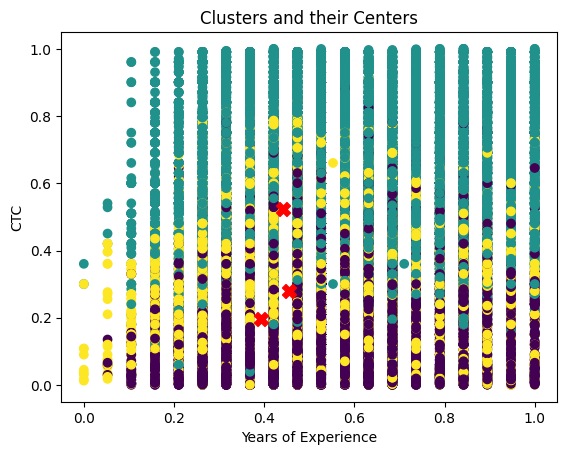

In [495]:
def viz_clusters(kmeans):
  plt.scatter(clusters['years_of_experience'], clusters['ctc'], c= clusters['label'])
  plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
              color = 'red',
              marker = 'X',
              s = 100)
  plt.xlabel('Years of Experience')
  plt.ylabel('CTC')
  plt.title('Clusters and their Centers')
  plt.show()

viz_clusters(kmeans)

- kmeans.cluster_centers_[:, 0] and kmeans.cluster_centers_[:, 1] represent the x and y coordinates of the cluster centers.

##### No clarity in visualization using scatter plot so using polar plot

Using the polar plot for better visualization

In [496]:
clusters.groupby('label').mean().reset_index()

,label,company_hash,ctc,job_position,years_of_experience,class,designation,tier
0,0,0.391840,0.196990,0.224561,0.475870,0.941970,0.969265,0.924564
1,1,0.440733,0.523932,0.233046,0.558725,0.042508,0.094832,0.090172
2,2,0.455073,0.280021,0.263733,0.465148,0.612220,0.095407,0.783092


In [497]:
# Using polar plot for better visialization:
polar = clusters.groupby(['label']).mean().reset_index()
polar = pd.melt(polar, id_vars=["label"])
polar

,label,variable,value
0,0,company_hash,0.391840
1,1,company_hash,0.440733
2,2,company_hash,0.455073
3,0,ctc,0.196990
4,1,ctc,0.523932
5,2,ctc,0.280021
6,0,job_position,0.224561
7,1,job_position,0.233046
8,2,job_position,0.263733
9,0,years_of_experience,0.475870


In [498]:
# !pip install plotly

In [499]:
import plotly.express as px

fig = px.line_polar(polar, r="value", theta="variable", color="label", line_close=True,height=700,width=800)
fig.show()

##### Insights Kmeans

**Super clarity in visualizing the clusters using polar line plots:**
- **Observations and Recommendations:**
- We have three cluster mainly (label - 0, 1, 2)
- `job_position` , `years of experience`, `comapny_hash` for all the people in the three cluster is nearly same. So we can compare the other features keeping this useful info in mind.
- The students **whose salaries are already high (Label 2)**, and who comes from a descent job role in a descent company, having slightly more amount experience, hardly care about designation , class or tier as they all are **best of all** !!
    - (Recomm.) Scaler should completely **ignore these students for advertising/marketing their product**  as they don't need to upskill as they already are **super skilled.**
    - (Recomm.) Instead, Scaler team should identify and talk to these folks **if they are interested in teaching/mentoring**. This way, Scaler would be having **best of the best instructors/mentors** in the business.
- The students **who have median salary (not too high, not too low) (Label 0)**, and who comes from a descent job role in a descent company, having descent amount experience, requires little upscalling.
    - (Recomm.) Scaler should advertise these set of students with **some advanced courses** so that they can compete with top tier students.
- The students **who have least salary (Label 1)**, and who comes from a descent job role in a descent company, having descent amount experience, **requires lots of upscalling**. As these students belongs to **designation - 3, class- 3, tier- 3**
    - (Recomm.) These are the target audience. Scaler team **should heavily focus on advertising / marketing all their tech products/ couses, free master clases**, to these set of learners

##### Hopkins using the library

In [500]:
!pip install pyclustertend

In [501]:
from pyclustertend import hopkins

In [502]:
data_new = clusters.copy()
data_new.head()

,company_hash,ctc,job_position,years_of_experience,class,designation,tier,label
0,0.015296,0.330330,0.495401,0.473684,0.0,0.0,0.5,1
1,0.508838,0.135134,0.308804,0.368421,1.0,1.0,1.0,0
2,0.000000,0.600600,0.137976,0.526316,0.0,0.0,0.0,1
3,0.318151,0.210210,0.137976,0.421053,1.0,1.0,1.0,0
4,0.521754,0.420420,0.308804,0.421053,0.0,0.0,0.0,1


In [503]:
data_new.drop('label', axis =1, inplace = True)
data_new.head()

,company_hash,ctc,job_position,years_of_experience,class,designation,tier
0,0.015296,0.330330,0.495401,0.473684,0.0,0.0,0.5
1,0.508838,0.135134,0.308804,0.368421,1.0,1.0,1.0
2,0.000000,0.600600,0.137976,0.526316,0.0,0.0,0.0
3,0.318151,0.210210,0.137976,0.421053,1.0,1.0,1.0
4,0.521754,0.420420,0.308804,0.421053,0.0,0.0,0.0


In [504]:
hop=hopkins(data_new,150) # sampling size also passed
hop

/usr/local/lib/python3.11/dist-packages/pyclustertend/hopkins.py:60: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/usr/local/lib/python3.11/dist-packages/pyclustertend/hopkins.py:63: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/usr/local/lib/python3.11/dist-packages/pyclustertend/hopkins.py:71: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



0.08014906496063703

##### Elbow Method for Optimal no of clusters

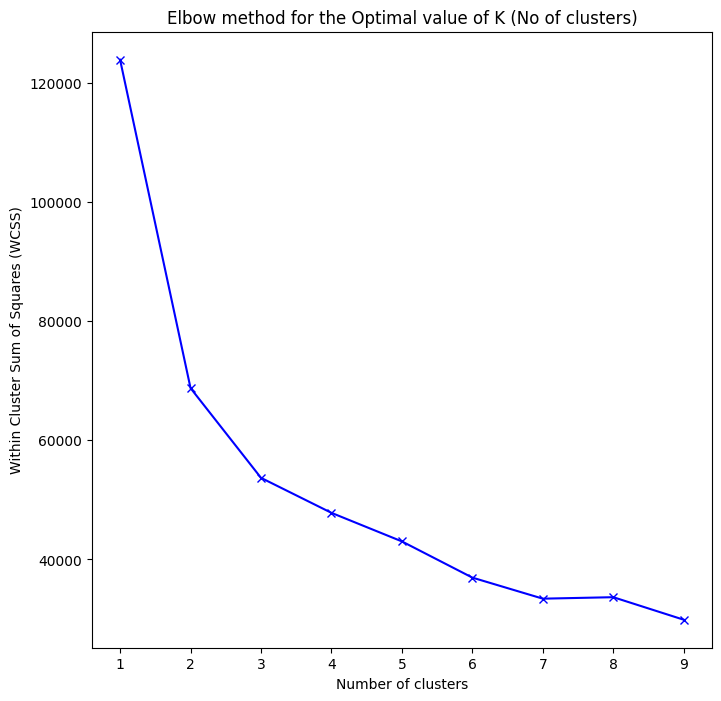

In [505]:
from sklearn.cluster import KMeans
plt.figure(figsize = (8, 8))
wcss = [] #empty list to save the WCSS values from the kmeans
k = range(1, 10)

for num_clusters in range(1, 10):
  kmeans = KMeans(n_clusters = num_clusters)
  kmeans.fit(data_new)
  wcss.append(kmeans.inertia_)

plt.plot(k ,wcss, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Within Cluster Sum of Squares (WCSS)')
plt.title('Elbow method for the Optimal value of K (No of clusters)')
plt.show()

In [506]:
'''
  'bx-': This specifies the style of the plot:
    'b': Blue color for the plot.
    'x': Markers in the shape of an 'x'.
    '-': Solid line connecting the markers.
'''

"\n  'bx-': This specifies the style of the plot:\n    'b': Blue color for the plot.\n    'x': Markers in the shape of an 'x'.\n    '-': Solid line connecting the markers.\n"

From above plot, it's clear that we require 3 clusters and our earlier assumption is correct.

In [507]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(data_new)
print(kmeans.cluster_centers_)
print(kmeans.cluster_centers_.shape)

[[0.36365537 0.37134406 0.20395962 0.5565788  0.3939419  0.72730274
  0.38013096]
 [0.45718812 0.47334715 0.25071769 0.53143178 0.10594265 0.01139835
  0.25560225]
 [0.41726405 0.19346238 0.23773801 0.45745807 0.97879332 0.69009567
  0.97339512]]
(3, 7)


In [508]:
# Adding the new columns for label using the kmeans clustering above
data_new['kmeans label'] = kmeans.fit_predict(data_new)
data_new.head()

,company_hash,ctc,job_position,years_of_experience,class,designation,tier,kmeans label
0,0.015296,0.330330,0.495401,0.473684,0.0,0.0,0.5,0
1,0.508838,0.135134,0.308804,0.368421,1.0,1.0,1.0,1
2,0.000000,0.600600,0.137976,0.526316,0.0,0.0,0.0,0
3,0.318151,0.210210,0.137976,0.421053,1.0,1.0,1.0,1
4,0.521754,0.420420,0.308804,0.421053,0.0,0.0,0.0,0


##### TSNE visualization

<ipython-input-509-ee2a3c0de0e5>:22: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



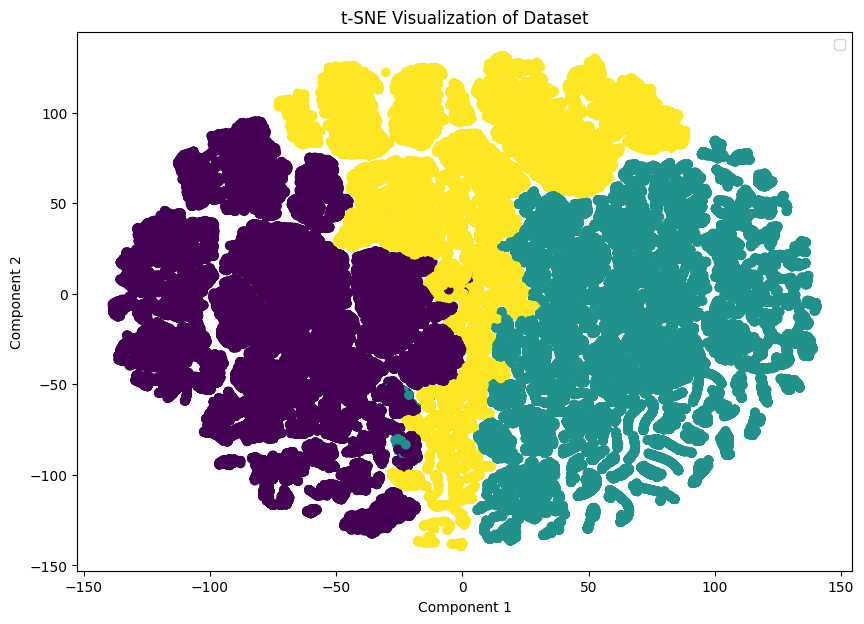

In [509]:
from sklearn.manifold import TSNE

X = data_new.drop(['kmeans label'], axis = 1)
y = data_new['kmeans label']

# Intialize tsne
tsne = TSNE(n_components = 2, random_state = 42)

# Fit and transform the data
X_tsne = tsne.fit_transform(X)

# # Create a DataFrame for the t-SNE results
df_tsne = pd.DataFrame(X_tsne, columns = ['Component 1', 'Component 2'] )
df_tsne['label'] = y

# Plot the t-SNE results
plt.figure(figsize=(10, 7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c = y)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('t-SNE Visualization of Dataset')
plt.legend()
plt.show()

In [510]:
df_cjy_cj_c

,company_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_experience,class,designation,count,mean,std,min,25%,50%,75%,max,tier
0,atrgxnnt xzaxv,2016.0,1100000,other,2020.0,9.0,1,1,9.0,1.115667e+06,4.581119e+05,500000.0,800000.0,1070000.0,1500000.0,1771000.0,2
1,qtrxvzwt xzegwgbb rxbxnta,2018.0,449999,fullstack engineer,2019.0,7.0,3,3,384.0,1.055291e+06,6.360957e+05,10000.0,600000.0,850000.0,1500000.0,3200000.0,3
2,Others,2015.0,2000000,backend engineer,2020.0,10.0,1,1,24903.0,9.647442e+05,7.601246e+05,15.0,390000.0,800000.0,1400000.0,3329999.0,1
3,ngpgutaxv,2017.0,700000,backend engineer,2019.0,8.0,3,3,59.0,1.455508e+06,6.554235e+05,200000.0,1075000.0,1300000.0,1850000.0,3160000.0,3
4,qxen sqghu,2017.0,1400000,fullstack engineer,2019.0,8.0,1,1,6.0,9.400000e+05,3.898718e+05,540000.0,625000.0,850000.0,1300000.0,1400000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146099,mvqwrvjo,2011.0,2250000,Others,2019.0,14.0,1,1,65.0,1.264431e+06,5.743451e+05,500000.0,800000.0,1040000.0,1600000.0,3200000.0,1
146100,vuurt xzw,2008.0,220000,Others,2019.0,17.0,3,1,16.0,1.568312e+06,1.231984e+06,60000.0,216250.0,2275000.0,2550000.0,3000000.0,3
146101,husqvawgb,2017.0,500000,Others,2020.0,8.0,3,3,97.0,1.275361e+06,5.880548e+05,200000.0,850000.0,1150000.0,1600000.0,3200000.0,3
146102,vwwgrxnt,2021.0,700000,Others,2021.0,4.0,3,1,157.0,1.344255e+06,5.743742e+05,200000.0,1000000.0,1300000.0,1500000.0,3000000.0,3


In [511]:
df_cjy_cj_c.drop(['count','mean','std','min','25%','50%','75%','max'], axis = 1, inplace=True)

In [512]:
final_data = pd.concat([df_cjy_cj_c,data_new['kmeans label']], axis=1)
final_data.head()

,company_hash,orgyear,ctc,job_position,ctc_updated_year,years_of_experience,class,designation,tier,kmeans label
0,atrgxnnt xzaxv,2016.0,1100000,other,2020.0,9.0,1,1,2,0
1,qtrxvzwt xzegwgbb rxbxnta,2018.0,449999,fullstack engineer,2019.0,7.0,3,3,3,1
2,Others,2015.0,2000000,backend engineer,2020.0,10.0,1,1,1,0
3,ngpgutaxv,2017.0,700000,backend engineer,2019.0,8.0,3,3,3,1
4,qxen sqghu,2017.0,1400000,fullstack engineer,2019.0,8.0,1,1,1,0


In [513]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146104 entries, 0 to 146103
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   company_hash         146104 non-null  object 
 1   orgyear              146104 non-null  float64
 2   ctc                  146104 non-null  int64  
 3   job_position         146104 non-null  object 
 4   ctc_updated_year     146104 non-null  float64
 5   years_of_experience  146104 non-null  float64
 6   class                146104 non-null  int64  
 7   designation          146104 non-null  int64  
 8   tier                 146104 non-null  int64  
 9   kmeans label         146104 non-null  int32  
dtypes: float64(3), int32(1), int64(4), object(2)
memory usage: 10.6+ MB


#### Hierarchical Clustering

In [514]:
data_frac=data_new.sample(frac=0.05)
#the most we could do without crashing

In [515]:
data_frac.shape

(7305, 8)

In [516]:
data_frac.drop('kmeans label', axis = 1, inplace = True)

In [517]:
data_frac.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7305 entries, 84657 to 4524
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company_hash         7305 non-null   float64
 1   ctc                  7305 non-null   float64
 2   job_position         7305 non-null   float64
 3   years_of_experience  7305 non-null   float64
 4   class                7305 non-null   float64
 5   designation          7305 non-null   float64
 6   tier                 7305 non-null   float64
dtypes: float64(7)
memory usage: 456.6 KB


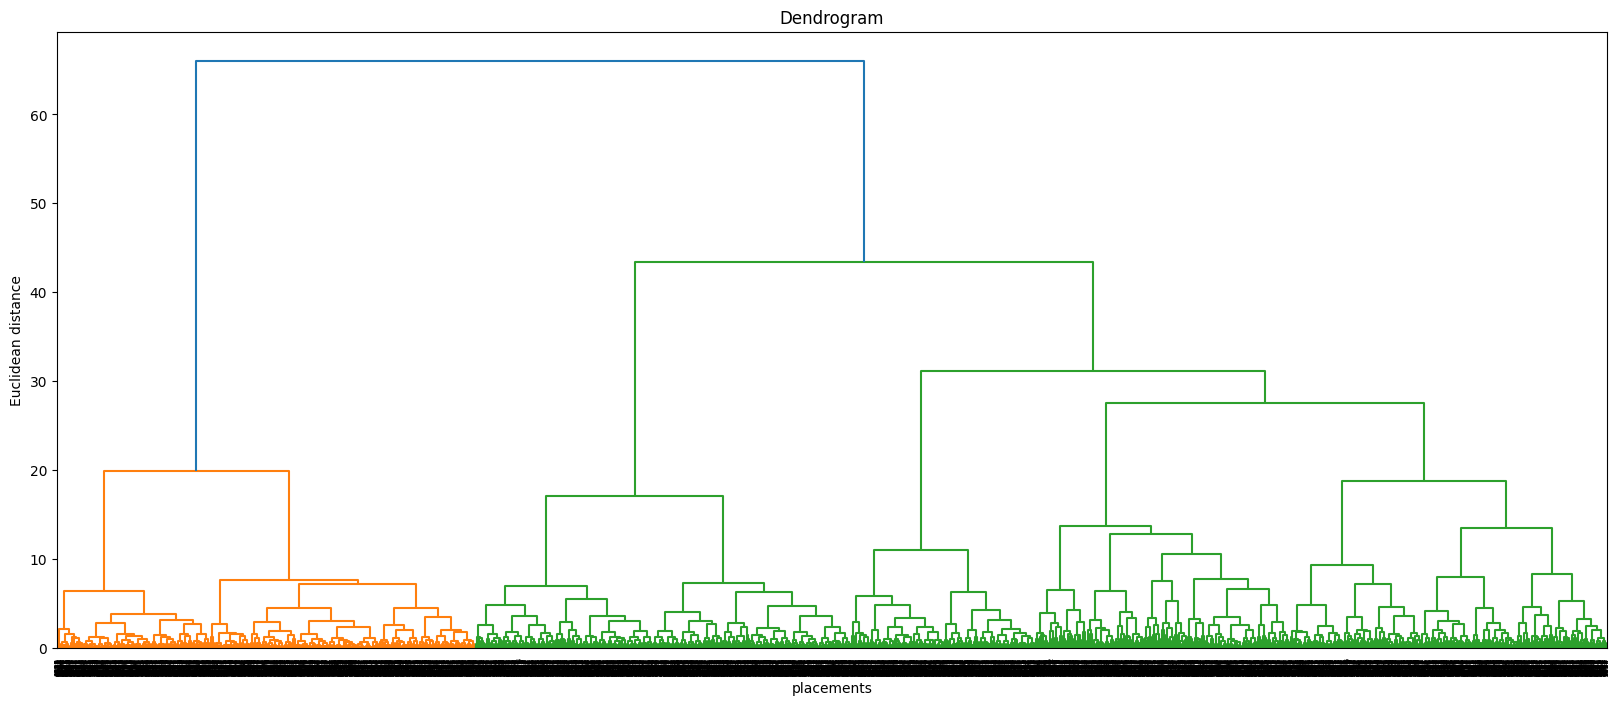

In [518]:
# Visual representation of the clusters using the dendodram
from scipy.cluster import hierarchy as sch

plt.figure(figsize = (20, 8))
dendrogram = sch.dendrogram(sch.linkage(data_frac, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('placements')
plt.ylabel('Euclidean distance')
plt.show()

In [519]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters = 3, metric = 'euclidean', linkage = 'ward')
model.fit(data_frac)

AgglomerativeClustering(n_clusters=3)

This is the data afer the Hierarchical clustering

In [520]:
data_frac['Aglo-label'] = model.fit_predict(data_frac)
data_frac

,company_hash,ctc,job_position,years_of_experience,class,designation,tier,Aglo-label
84657,0.093474,0.690691,0.137976,0.631579,0.5,0.5,0.5,0
84063,0.959891,0.345345,0.000000,0.263158,0.5,0.5,0.5,0
106841,0.439497,0.765766,0.593955,0.421053,0.5,0.5,0.0,0
105583,0.440517,0.420420,0.302234,0.421053,0.0,1.0,0.5,0
32085,0.422502,0.720721,0.000000,0.631579,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...
31704,0.783821,0.270270,0.137976,0.789474,0.0,0.0,0.5,0
128330,0.125085,0.312312,0.302234,0.789474,0.0,0.0,0.0,2
119843,0.255269,0.397898,0.137976,0.684211,0.5,1.0,0.0,0
52151,0.833787,0.450450,0.308804,0.736842,1.0,1.0,1.0,1


In [521]:
data_frac.groupby('Aglo-label').median()

,company_hash,ctc,job_position,years_of_experience,class,designation,tier
Aglo-label,,,,,,,
0,0.391400,0.285285,0.235217,0.473684,0.5,0.0,0.5
1,0.342964,0.135135,0.137976,0.421053,1.0,1.0,1.0
2,0.407886,0.570570,0.137976,0.526316,0.0,0.0,0.0


We can submit this data to marketing team so that they can focus on those clusters of students who are in dire need and are willing to move forward in life.

<ipython-input-522-4c890842a407>:22: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



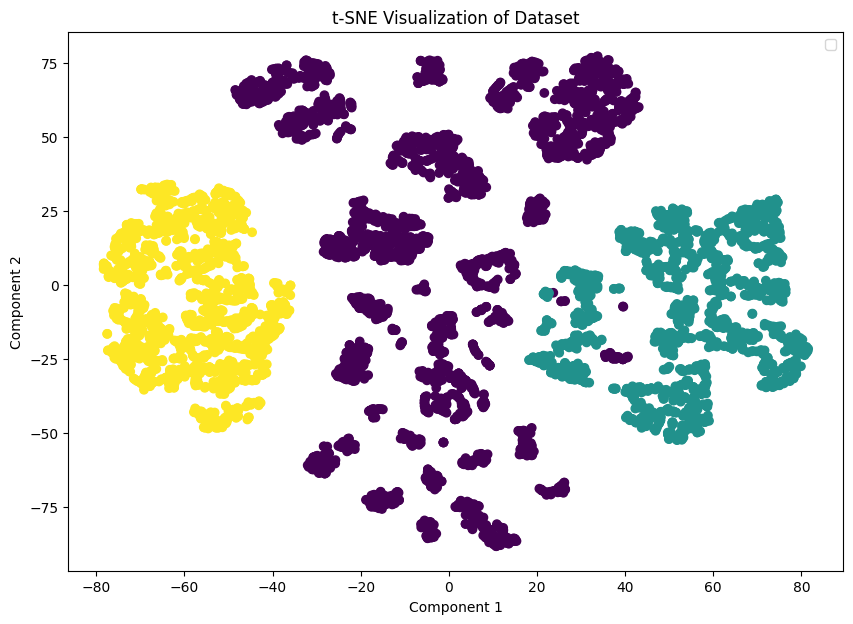

In [522]:
from sklearn.manifold import TSNE

X = data_frac.drop(['Aglo-label'], axis = 1)
y = data_frac['Aglo-label']

# Intialize tsne
tsne = TSNE(n_components = 2, random_state = 42)

# Fit and transform the data
X_tsne = tsne.fit_transform(X)

# # Create a DataFrame for the t-SNE results
df_tsne = pd.DataFrame(X_tsne, columns = ['Component 1', 'Component 2'] )
df_tsne['label'] = y

# Plot the t-SNE results
plt.figure(figsize=(10, 7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c = y)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('t-SNE Visualization of Dataset')
plt.legend()
plt.show()